In [39]:
from sklearn import tree, metrics
import pandas as pd
from sklearn import model_selection
import matplotlib.pyplot as plt
import graphviz
from sklearn.model_selection import train_test_split
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix

## Build a Decision Tree Classifier

The following method accepts a few model and hyper-parameter values and returns a decision tree.

In [126]:
def dt_train(X, y, **kwargs):
    max_depth = kwargs.get('max_depth', None)
    random_state = kwargs.get('random_state',7)
    criterion = kwargs.get('criterion', 'gini')
    min_samples_leaf = kwargs.get('min_samples_leaf', 1.0)
    ccp_alpha = kwargs.get('alpha', 0.0)
    balance = kwargs.get('balance')
    
    dt = tree.DecisionTreeClassifier(max_depth=max_depth, random_state=random_state, criterion='entropy', 
                                     class_weight=balance, ccp_alpha=ccp_alpha)
    dt.fit(X, y)
    return dt

The following method accepts a decision tree classification model and perform post pruning

In [3]:
def prune(dt, X, y):
    path = dt.cost_complexity_pruning_path(X, y)
    return path

## Utilities for analysis

The following method builds a validation curve for a decision tree classification model based on a set of model and hyperparameter values. 

In [4]:
def plot_validation_curve(dt, X, y, param_name, param_range, cross_validation=5, fig_name="validation_curve.png"):
    tr_sc, tst_sc = model_selection.validation_curve(dt, X, y, param_name=param_name,
                                                            param_range=param_range, cv=cross_validation)
    plt.figure()
    plt.xticks(param_range)
        
    plt.xlabel(param_name)
    plt.ylabel("Score")
    plt.plot(param_range, np.mean(tr_sc, axis=1), label='Training score')
    plt.plot(param_range, np.mean(tst_sc, axis=1), label='Cross-validation score')
    plt.legend(loc="best")
    plt.title('Decision Tree - Validation Curve')
    
    plt.savefig(fig_name)
    plt.show()


Get classification score

In [5]:
def get_classification_score(dt, X, y):
    return dt.score(X, y)

The following function provides a visual representation for the decision tree

In [6]:
def visualize_dt(dt, feature_names, target_names):
    exp_tree = tree.export_graphviz(dt, out_file=None, 
                      feature_names=feature_names,  
                      class_names=target_names,  
                      filled=True, rounded=True)
    return graphviz.Source(exp_tree)
    

## Census Data Analysis
Extraction was done by Barry Becker from the 1994 Census database. A set of reasonably clean records was extracted using the following conditions: ((AAGE>16) && (AGI>100) && (AFNLWGT>1)&& (HRSWK>0))

Prediction task is to determine whether a person makes over 50K a year.

In [120]:
data = pd.read_csv("adult.data", sep='\t', header=None, 
                   names=["age", "workclass", "fnlwgt", "education", 
                          "education-num", "marital-status", "occupation",
                          "relationship", "race", "sex", "capital-gain", 
                          "capital-loss", "hours-per-week", "native-country", 
                          "output"])
data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,output
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


From the pearson correlation plot below, it can be inferred that there is not much correlation between the input columns and the output value.

Now, let us take a look at the number of samples for each of the discrete output values. 

<AxesSubplot:xlabel='output', ylabel='count'>

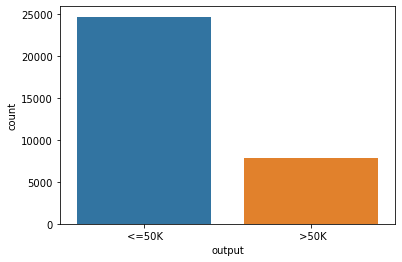

In [127]:
sns.countplot(x="output", data=data)

There is a gap between the number of persons who make >50k/year vs the number of persons who do not. 

In [128]:
categorical_vars =["workclass", "education", "marital-status", "occupation", "relationship", 
                   "race", "sex", "native-country"]
df = data.copy()
for var in categorical_vars:
    df[var] = pd.Categorical(df[var])
    df[var] = df[var].cat.codes

continuous_vars = ["fnlwgt", "capital-gain", "capital-loss"]
for var in continuous_vars:
    df[var] = (df[var]-df[var].mean())/df[var].std()

normalized_df=(df-df.mean())/df.std()
y = df.output.values
X = df.drop(['output'], axis=1)
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,output
0,39,7,-1.063594,9,13,4,1,1,4,1,0.148451,-0.216656,40,39,<=50K
1,50,6,-1.008692,9,13,2,4,0,4,1,-0.145918,-0.216656,13,39,<=50K
2,38,4,0.245075,11,9,0,6,1,4,1,-0.145918,-0.216656,40,39,<=50K
3,53,4,0.425795,1,7,2,6,0,2,1,-0.145918,-0.216656,40,39,<=50K
4,28,4,1.408154,9,13,2,10,5,2,0,-0.145918,-0.216656,40,5,<=50K


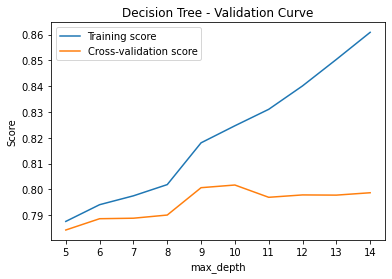

In [129]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=7)
plot_validation_curve(tree.DecisionTreeClassifier(class_weight="balanced"), X_train, y_train, 'max_depth', range(5, 15), 
                      fig_name="max_depth_vc.png")

Now let us call the training function with max depth as 4 and take a look at the results. 

In [136]:
dt = dt_train(X_train, y_train, max_depth=10, balance="balanced")

Now let us measure the performance of the model on the test set:

In [137]:
get_classification_score(dt, X_test, y_test)

0.811761093198219

As there are too much of negative examples, it is important to see confusion matrix to measure the actual model performance. 

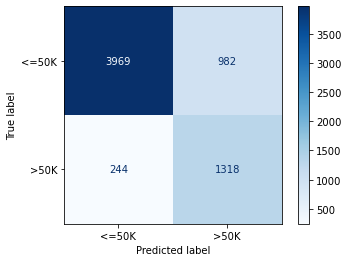

In [138]:
plot_confusion_matrix(dt, X_test, y_test,
                                 display_labels=['<=50K', '>50K'],
                                 cmap=plt.cm.Blues)
plt.show()

With the above model, it can be seen that the model does not fit well to positive examples. 
One way to deal with this is allow the model to overfit the data and perform post pruning.

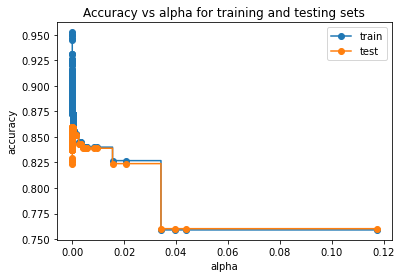

In [139]:
dt_final = dt_train(X_train, y_train, max_depth=20)
path = prune(dt_final, X_train, y_train)
ccp_alphas = path.ccp_alphas
clfs = []
for ccp_alpha in ccp_alphas:
    dt_f = tree.DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha, max_depth=20)
    dt_f.fit(X_train, y_train)
    clfs.append(dt_f)
    
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

In [153]:
dt_f = tree.DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alphas[np.argmax(test_scores)], max_depth=20)
dt_f.fit(X_train, y_train)
dt_f.score(X_test, y_test)

0.8593582066635959

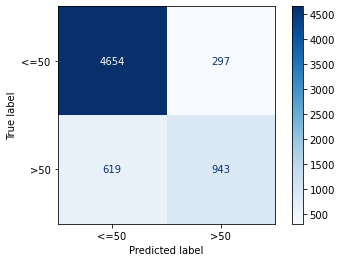

In [145]:
plot_confusion_matrix(dt_f, X_test, y_test,
                                 display_labels=['<=50', '>50'],
                                 cmap=plt.cm.Blues)
plt.show()

Although we allow the model to overfit and perform post pruning, the model does not perform well on positive examples. Let us take a look at the f1-score for the pruned trees and choose the model that balances both of these classes. 

In [146]:
f1_scores_pos = []
f1_scores_neg = []
for clf in clfs:
    y_actual = clf.predict(X_test)
    f1_scores_pos.append(metrics.f1_score(y_test, y_actual, pos_label=' >50K'))
    f1_scores_neg.append(metrics.f1_score(y_test, y_actual, pos_label=' <=50K'))

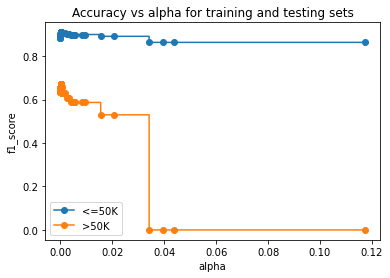

In [147]:
fig, ax = plt.subplots()
    
ax.set_xlabel("alpha")
ax.set_ylabel("f1_score")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, f1_scores_neg, marker='o', label="<=50K",
        drawstyle="steps-post")
ax.plot(ccp_alphas, f1_scores_pos, marker='o', label=">50K",
        drawstyle="steps-post")
ax.legend()

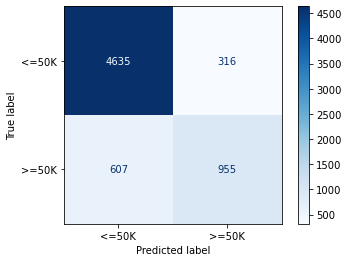

In [151]:
dt_f_pos = tree.DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alphas[np.argmax(f1_scores_pos)], max_depth=20)
dt_f_pos.fit(X_train, y_train)
plot_confusion_matrix(dt_f_pos, X_test, y_test,
                                 display_labels=['<=50K', '>=50K'],
                                 cmap=plt.cm.Blues)
plt.show()

In [149]:
dt_f_pos.score(X_test, y_test)

0.8582834331337326